### Setup

#### 1. Install required libraries

This only nees to be installed once

In [1]:
# install.packages("UpSetR")
# install.packages("ggfortify")
# install.packages("vegan")
# install.packages("philentropy")
# install.packages("randomForest")
# install.packages("dplyr")

Installing package into ‘/Users/mann/Library/R/3.6/library’
(as ‘lib’ is unspecified)



#### 2. Load required libraries

In [26]:
library(UpSetR)
library(ggfortify)
library(vegan)
library(philentropy)
library(randomForest)
library(dplyr)

#### 3. Load data into R

In [27]:
map <- read.table("map.txt", sep="\t", header=T, row.names=1)
seqtab <- read.table("../01-read_processing/sequence_table.merged.txt", header=T, row.names=1)
tax <- read.table("tax.txt", header=T, sep="\t")

#### 4. Filter out any samples not found in metadata or raw data

In [28]:
notinmeta <- setdiff(row.names(seqtab), row.names(map))
notinraw <- setdiff(row.names(map), row.names(seqtab))
notinmeta
notinraw

[1] "YEAST"

character(0)

In [29]:
seqtab.filt <- seqtab[rownames(seqtab) %in% rownames(map),]
head(seqtab.filt)

,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10,⋯,ASV482,ASV483,ASV484,ASV485,ASV486,ASV487,ASV488,ASV489,ASV490,ASV491
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
TM01-03,34,0,3280,0,69,0,15,60,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TM01-04,297,0,2191,0,0,0,6,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TM02-02,323,4940,159,0,1384,94,1440,503,64,88,⋯,0,0,0,0,0,0,0,0,0,0
TM02-03,20,0,632,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TM02-04,133,952,70,0,0,0,1135,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TM03-01,182,68,289,0,101,0,70,92,0,39,⋯,0,0,0,0,0,0,0,0,0,0


### Microeuk analyses

#### 1. Get sequence table with only *Blastocystis* ASVs

In [30]:
tax.blast <- tax[grepl("Blastocystis", tax$Taxon),]
seqtab.blast <- seqtab.filt[colnames(seqtab.filt) %in% tax.blast$ASVID]
head(tax.blast)
head(seqtab.blast)

,ASVID,Taxon
,<fct>,<fct>
25,ASV140,Blastocystis
26,ASV158,Blastocystis
27,ASV20,Blastocystis
28,ASV213,Blastocystis
29,ASV221,Blastocystis
30,ASV223,Blastocystis


,ASV1,ASV2,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10,ASV15,⋯,ASV370,ASV376,ASV377,ASV380,ASV392,ASV417,ASV424,ASV443,ASV449,ASV454
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
TM01-03,34,0,0,69,0,15,60,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TM01-04,297,0,0,0,0,6,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TM02-02,323,4940,0,1384,94,1440,503,64,88,0,⋯,0,0,0,0,0,0,0,0,0,0
TM02-03,20,0,0,0,0,0,0,0,0,5,⋯,0,0,0,0,0,0,0,0,0,0
TM02-04,133,952,0,0,0,1135,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TM03-01,182,68,0,101,0,70,92,0,39,0,⋯,0,0,0,0,0,0,0,0,0,0


#### 2. *Blastocystis* upset plot

Warning message in Ops.factor(left, right):
“‘>’ not meaningful for factors”


pdf 
  2

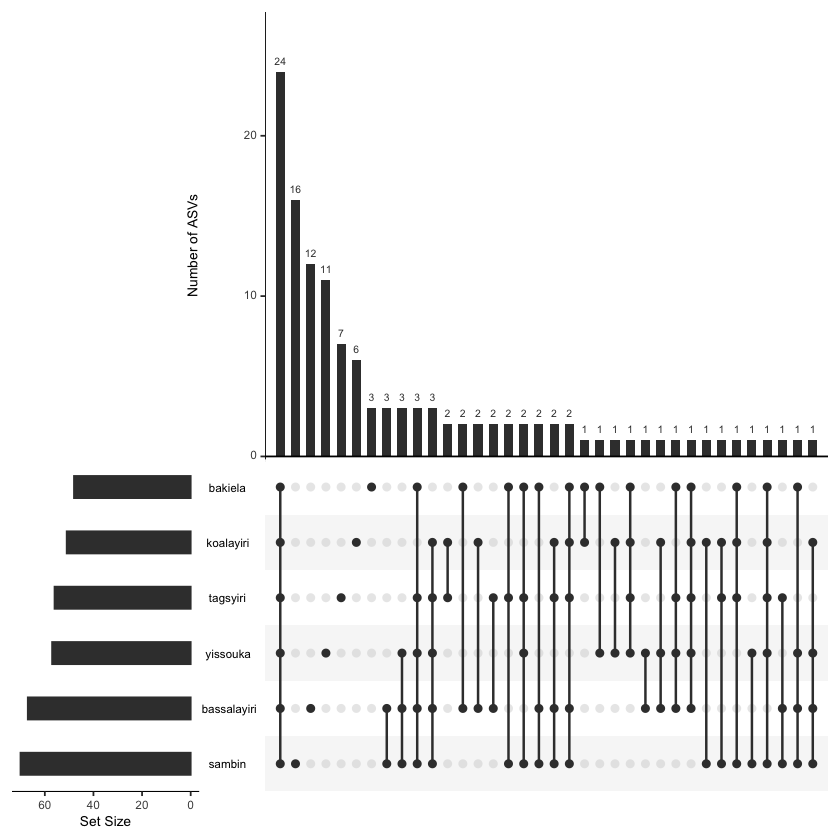

In [31]:
map <- as.matrix(map)
merged <- merge(seqtab.blast, map, by="row.names")
# only include quartiers with five or more representatives
keep <- c("badma", "bakiela", "bassalayiri", "koalayiri", "mougousin", "sambin", "tagsyiri", "yissouka")
merged <- merged[merged$quartier_name %in% keep,]
# aggregate table
n <- ncol(seqtab.blast) + 1
agg <- aggregate(merged[,2:n], by=list(merged$quartier_name), FUN=sum)
# remove any columns with all zeros
agg <- agg[,colSums(agg !=0) > 0]
rownames(agg) <- agg$Group.1
# convert to presence/absence table
agg[agg>1] <- 1
agg <- data.frame(t(agg[,-1]))
# generate plot -- ignore warning message
blast.up <- upset(agg, order.by="freq", mainbar.y.label="Number of ASVs", sets.x.label="Set Size", mb.ratio = c(0.55, 0.45), nsets=8)
pdf("upset_blasto_quartier.pdf")
blast.up
dev.off()
blast.up

#### 3. *Blastocystis* diversity 

First generate jaccard distance matrix and get pca 

In [34]:
# getDistMethods()
dist <- philentropy::distance(seqtab.blast, method="jaccard", use.row.names = T)
head(dist)
pca <- prcomp(dist)

Metric: 'jaccard'; comparing: 80 vectors.



,TM01-03,TM01-04,TM02-02,TM02-03,TM02-04,TM03-01,TM03-04,TM04-01,TM04-02,TM04-03,⋯,TM26-03,TM27-01,TM27-03,TM28-01,TM28-02,TM28-03,TM28-04,TM29-02,TM29-03,TM30-01
TM01-03,0.0000000,0.8821429,0.9941645,0.9241256,0.9846831,0.6418589,0.5189864,0.9991920,0.8854945,0.9992997,⋯,0.9964645,0.9954368,0.9944871,0.9897127,0.9984864,0.9465642,0.9951402,0.9996134,0.9946889,0.9979930
TM01-04,0.8821429,0.0000000,0.9961819,0.9265137,0.9774419,0.4420495,0.9114804,0.9966985,1.0000000,0.9939109,⋯,0.9790401,0.9988319,0.9588408,0.9790504,0.9954833,0.9900080,0.9612299,0.9979813,0.9963816,0.9927719
TM02-02,0.9941645,0.9961819,0.0000000,0.9995904,0.7398511,0.9759165,0.9941716,0.9976884,0.9989011,0.9914156,⋯,0.9883052,0.9129411,0.9644413,0.7922413,0.9749147,0.9742191,0.9672778,0.9960924,0.9656011,0.9477237
TM02-03,0.9241256,0.9265137,0.9995904,0.0000000,0.9967085,0.9324823,0.8942559,0.9993776,1.0000000,0.9995920,⋯,0.9985976,0.9974398,0.9973266,0.9987063,0.9996967,0.9989262,0.9969586,0.9998525,0.9997494,0.9995114
TM02-04,0.9846831,0.9774419,0.7398511,0.9967085,0.0000000,0.9244429,0.9939194,0.9956989,1.0000000,0.9972389,⋯,0.9924348,0.8216882,0.9827301,0.2920496,0.9879998,0.9906088,0.9747638,0.9987564,0.9855211,0.9926345
TM03-01,0.6418589,0.4420495,0.9759165,0.9324823,0.9244429,0.0000000,0.7653689,0.9968874,0.9646150,0.9962634,⋯,0.9854614,0.9784572,0.9736334,0.8925260,0.9951952,0.9125589,0.9752667,0.9985102,0.9906345,0.9935730


pdf 
  2

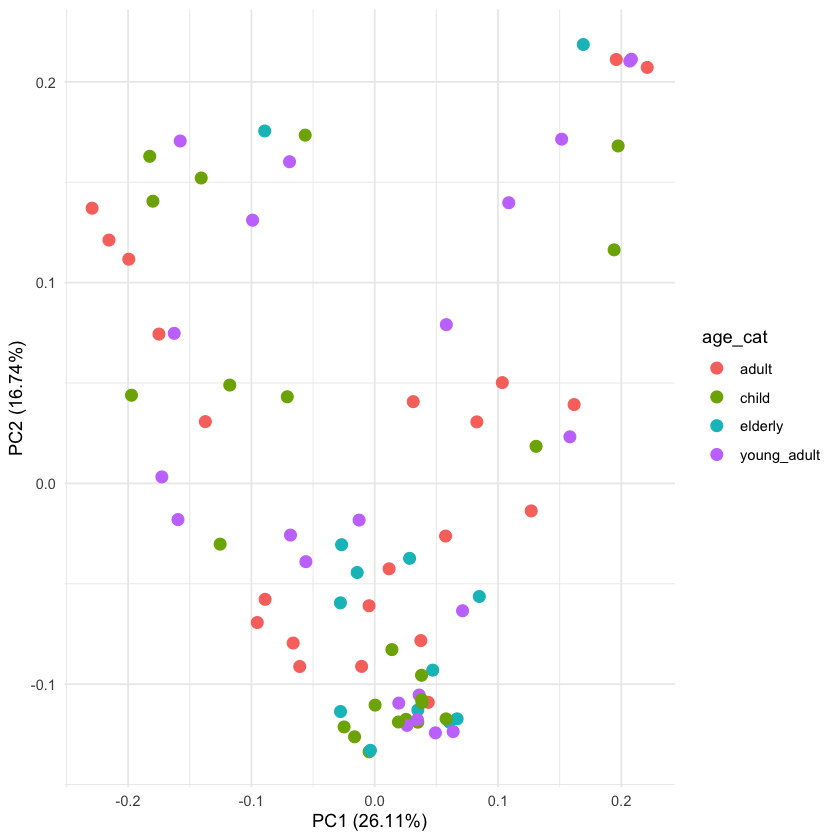

In [35]:
bdiv_age <- autoplot(pca, data=map, colour='age_cat', size=3) + theme_minimal()
bdiv_age
pdf("bdiv_age.pdf")
bdiv_age
dev.off()

No clustering by age, sex, water source/treatment, antiparasitics, livestock etc

In [9]:
adonis(formula= dist ~ Ent_binary, data=as.data.frame(map))


Call:
adonis(formula = dist ~ Ent_binary, data = as.data.frame(map)) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)  
Ent_binary  1     0.612 0.61193  1.3858 0.01746  0.082 .
Residuals  78    34.443 0.44158         0.98254         
Total      79    35.055                 1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Random forest prediction? Only include quartiers with five or more representatives

In [36]:
t.seqtab.blast <- t(seqtab.blast)
map <- as.data.frame(map)
metadata <- map[map$quartier_name %in% c("badma", "bakiela", "bassalayiri", "koalayiri", "mougousin", "sambin", "tagsyiri", "yissouka"),]
metadata$quartier_name <- factor(metadata$quartier_name)
nonzero_counts <- apply(t.seqtab.blast, 1, function(y) sum(length(which(y > 0))))
# fucntion to remove rare ASVs
remove_rare <- function( table , cutoff_pro ) {
  row2keep <- c()
  cutoff <- ceiling( cutoff_pro * ncol(table) )  
  for ( i in 1:nrow(table) ) {
    row_nonzero <- length( which( table[ i , ]  > 0 ) ) 
    if ( row_nonzero > cutoff ) {
      row2keep <- c( row2keep , i)
    }
  }
  return( table [ row2keep , , drop=F ])
}
# remove rare ASVs and generate random forest predictions
asv_table_rare_removed <- remove_rare(table=t.seqtab.blast, cutoff_pro=0.001)
asv_table_rare_removed_norm <- sweep(asv_table_rare_removed, 2, colSums(asv_table_rare_removed), '/')*100
asv_table_scaled <- scale(asv_table_rare_removed_norm, center=T, scale=T)
asv_table_scaled_var <- data.frame(t(asv_table_scaled))
asv_table_scaled_var$var <- metadata[rownames(asv_table_scaled_var), "quartier_name"]
set.seed(151)
asv_table_scaled_var <- asv_table_scaled_var %>% filter(!is.na(var))
rf <- randomForest(x=asv_table_scaled_var[,1:(ncol(asv_table_scaled_var)-1)], y=asv_table_scaled_var[, ncol(asv_table_scaled_var)], ntree=10000, importance=T, proximity=T)
rf                      


Call:
 randomForest(x = asv_table_scaled_var[, 1:(ncol(asv_table_scaled_var) -      1)], y = asv_table_scaled_var[, ncol(asv_table_scaled_var)],      ntree = 10000, importance = T, proximity = T) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 9

        OOB estimate of  error rate: 84.21%
Confusion matrix:
            bakiela bassalayiri koalayiri sambin tagsyiri yissouka class.error
bakiela           0           0         1      2        2        1   1.0000000
bassalayiri       0           2         0      0        1        4   0.7142857
koalayiri         0           0         0      0        2        5   1.0000000
sambin            0           0         1      1        5        4   0.9090909
tagsyiri          0           0         0      3        3        6   0.7500000
yissouka          2           1         2      3        3        3   0.7857143

So not predictive when you only include larger quartiers, remove rare ASVs

Create phyloseq object

In [38]:
library(phyloseq)
ps.dat <- phyloseq(otu_table(seqtab.blast, taxa_are_rows=F), sample_data(map))
ps.dat

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 144 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 59 sample variables ]

Alpha diversity

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


pdf 
  2

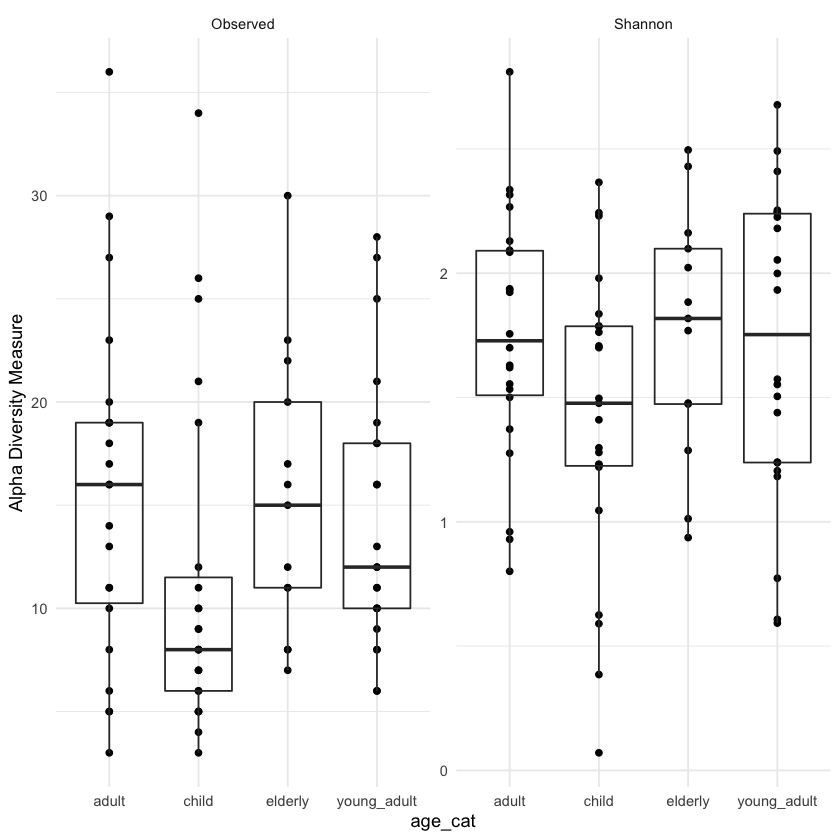

In [41]:
adiv_age <- plot_richness(ps.dat, x="age_cat", measures=c("Observed", "Shannon")) + geom_boxplot(alpha=0.0) + theme_minimal()
adiv_age
pdf("adiv_age.pdf")
adiv_age
dev.off()

In [21]:
rich <- estimate_richness(ps.dat)
head(rich)

Warning message in estimate_richness(ps.dat):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


,Observed,Chao1,se.chao1,ACE,se.ACE,Shannon,Simpson,InvSimpson,Fisher
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TM01.03,11,11,0,11,0.9534626,2.2259091,0.8763659,8.088384,2.1792852
TM01.04,4,4,0,4,1.0000000,0.3855295,0.1708423,1.206043,0.6414414
TM02.02,23,23,0,NaN,NaN,1.9373342,0.7445884,3.915249,2.7862677
TM02.03,8,8,0,8,1.3693064,1.9991465,0.8537415,6.837209,2.1740465
TM02.04,7,7,0,7,1.1952286,1.2789957,0.6799440,3.124453,0.8675330
TM03.01,13,13,0,13,1.5191091,2.0923084,0.8425675,6.351928,2.3107187


In [37]:
pairwise.wilcox.test(rich$Observed, sample_data(ps.dat)$age_cat, p.adj = "bonf")

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”



	Pairwise comparisons using Wilcoxon rank sum test 

data:  rich$Observed and sample_data(ps.dat)$age_cat 

            adult child elderly
child       0.27  -     -      
elderly     1.00  0.20  -      
young_adult 1.00  0.15  1.00   

P value adjustment method: bonferroni 